In [1]:
import numpy
import time

from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector

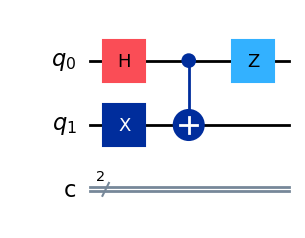

In [2]:
# Étape 1 :
def create_entangled_pair_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(2, 2)
    circuit.x(1)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.z(0)
    return circuit

# Ce bloc crée un circuit à 2 qubits et prépare l’état intriqué demandé par le sujet.

# Affichage
def display_step1_result():
    circuit = create_entangled_pair_circuit()
    display(circuit.draw("mpl"))

display_step1_result()

(0,0)


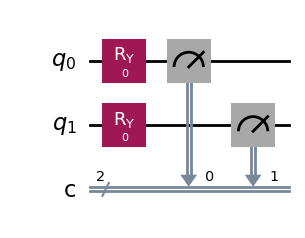

(-30,0)


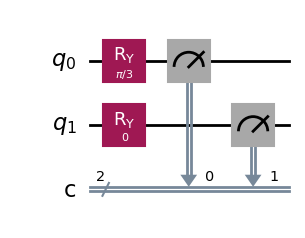

(0,30)


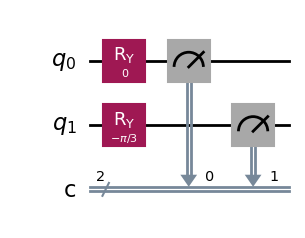

(-30,30)


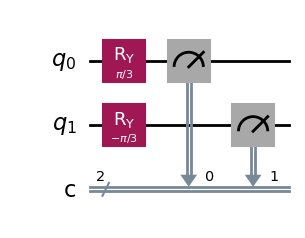

In [3]:
# Étape 2 :
def create_measurement_circuit(angle_a_deg: float, angle_b_deg: float) -> QuantumCircuit:
    qc = QuantumCircuit(2, 2)

    theta_a = numpy.deg2rad(-2 * angle_a_deg)
    theta_b = numpy.deg2rad(-2 * angle_b_deg)
    qc.ry(theta_a, 0)
    qc.ry(theta_b, 1)
    qc.measure(0, 0)
    qc.measure(1, 1)

    return qc

# Le circuit prépare l’état quantique à deux qubits :
# |ψ⟩ = (R_y(-2α) ⊗ R_y(-2β)) |00⟩
#     = (cos(α)|0⟩ - sin(α)|1⟩) ⊗ (cos(β)|0⟩ - sin(β)|1⟩),
# puis effectue une mesure |0⟩,|1⟩ sur chacun des qubits.

def create_all_measurement_circuits() -> list[tuple[str, QuantumCircuit]]:
    return [
        ("(0,0)", create_measurement_circuit(0, 0)),
        ("(-30,0)", create_measurement_circuit(-30, 0)),
        ("(0,30)", create_measurement_circuit(0, 30)),
        ("(-30,30)", create_measurement_circuit(-30, 30)),
    ]

# Ce bloc construit les 4 circuits de mesure correspondant aux orientations imposées par le sujet.
# On applique les rotations associées aux angles (0,0), (-30,0), (0,30) et (-30,30), puis on mesure les 2 qubits.

# Affichage
def display_step2_result():
    for label, circuit in create_all_measurement_circuits():
        print(label)
        display(circuit.draw("mpl"))

display_step2_result()

In [4]:
# Étape 3 :
def generate_random_measurement_settings(batch_size: int) -> tuple[list[int], list[int]]:
    rng = numpy.random.default_rng()
    alice = rng.integers(0, 2, size=batch_size).tolist()
    bob = rng.integers(0, 2, size=batch_size).tolist()

    return alice, bob

# Ce bloc génère deux listes aléatoires.

# Affichage
def display_step3_result():
    alice, bob = generate_random_measurement_settings(10)
    print("Alice settings:", alice)
    print("Bob settings:", bob)

display_step3_result()

Alice settings: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
Bob settings: [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


In [5]:
# Étape 4 :
def choose_measurement_circuit_randomly(measurement_circuits: list[QuantumCircuit], rng: numpy.random.Generator) -> QuantumCircuit:
    index = int(rng.integers(0, len(measurement_circuits)))
    return measurement_circuits[index]

def run_step4_random_batch(initial_state: QuantumCircuit, measurement_circuits: list[QuantumCircuit], batch_size: int = 1024) -> list[str]:
    sampler = StatevectorSampler()
    rng = numpy.random.default_rng()
    results = []

    for _ in range(batch_size):
        measurement = choose_measurement_circuit_randomly(measurement_circuits, rng)
        full_circuit = initial_state.compose(measurement, inplace=False)
        job = sampler.run([full_circuit], shots=1)
        result = job.result()
        bitstring = result[0].data.c.get_bitstrings()[0]
        results.append(bitstring)

    return results

# Ce bloc répète le protocole sur un batch en composant l’état initial avec un circuit de mesure choisi aléatoirement.
# Chaque exécution est faite avec un seul tir (shots=1) afin de simuler une paire de photons mesurée une fois.
# Les résultats sont stockés sous forme de bitstrings pour être exploités aux étapes suivantes.

# Affichage
def display_step4_result():
    initial_state = create_entangled_pair_circuit()
    measurement_circuits = [circuit for _, circuit in create_all_measurement_circuits()]
    results = run_step4_random_batch(initial_state, measurement_circuits, batch_size=10)
    print("Measurement results:", results)

display_step4_result()

Measurement results: ['11', '00', '11', '11', '01', '00', '01', '00', '01', '00']


In [6]:
# Étape 5 :
def extract_alice_bit_from_bitstring(bitstring: str) -> int:
    return int(bitstring[1])

def extract_key_from_results(bitstrings: list[str]) -> list[int]:
    key = []

    for bitstring in bitstrings:
        key.append(int(bitstring[1]))  # bit d'Alice

    return key

# Ce bloc extrait les bits de mesure côté Alice et les stocke dans une liste représentant la clé.

# Affichage
def display_step5_result():
    initial_state = create_entangled_pair_circuit()
    measurement_circuits = [circuit for _, circuit in create_all_measurement_circuits()]
    results = run_step4_random_batch(initial_state, measurement_circuits, batch_size=10)
    key = extract_key_from_results(results)
    print("Alice's secret key bits:", key)

display_step5_result()

Alice's secret key bits: [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [7]:
# Étape 6 - 7 :
def create_rotation_circuit(angle_a_deg: float, angle_b_deg: float) -> QuantumCircuit:
    qc = QuantumCircuit(2)
    qc.ry(numpy.deg2rad(-2 * angle_a_deg), 0)
    qc.ry(numpy.deg2rad(-2 * angle_b_deg), 1)

    return qc

def estimate_p00_for_angles(initial_state: QuantumCircuit,angle_a_deg: float,angle_b_deg: float,shots: int = 1024) -> float:
    rotation = create_rotation_circuit(angle_a_deg, angle_b_deg)
    qc = initial_state.compose(rotation, inplace=False)
    state = Statevector(qc)
    probabilities = numpy.abs(state.data) ** 2
    rng = numpy.random.default_rng()
    outcomes = rng.choice(4, size=shots, p=probabilities)

    return numpy.sum(outcomes == 0) / shots

def run_step_6_7_batch(initial_state: QuantumCircuit) -> float:
    p1 = estimate_p00_for_angles(initial_state, -30.0, 0.0)
    p2 = estimate_p00_for_angles(initial_state, 0.0, 30.0)
    p3 = estimate_p00_for_angles(initial_state, -30.0, 30.0)

    return p1 + p2 - p3

# Ce bloc estime les probabilités p(a=0,b=0) pour les trois configurations non parallèles demandées.
# À partir de ces trois valeurs, on calcule W selon la formule du sujet pour évaluer la sécurité du batch.

# Affichage
def display_step6_7_result():
    initial_state = create_entangled_pair_circuit()
    s = run_step_6_7_batch(initial_state)
    print("S =", s)

display_step6_7_result()

S = -0.1259765625


In [8]:
# Étape 8 - 9 - 10 - 11 :
def create_product_state_circuit() -> QuantumCircuit:
    qc = QuantumCircuit(2, 2)
    qc.x(1)  # |01>
    return qc

def choose_initial_state_circuit() -> QuantumCircuit:
    rng = numpy.random.default_rng()
    if rng.integers(0, 2) == 1:
        return create_product_state_circuit()
    return create_entangled_pair_circuit()

def run_batches():
    batch = 0

    while True:
        time.sleep(1)
        batch += 1
        initial_state = choose_initial_state_circuit()
        W = run_step_6_7_batch(initial_state)

        print(f"Batch {batch} | W = {W:.4f}")
        if W > 0:
            print("Alert : someone is listening!")

run_batches()

# Ce bloc enchaîne des batches successifs en relançant automatiquement le protocole à chaque itération.
# On simule la présence d’un espion en pouvant démarrer certains batches avec un état produit au lieu de l’état intriqué.
# À chaque batch, on affiche W et déclenche une alerte dès que W devient positif, comme demandé dans le sujet.

Batch 1 | W = -0.1562
Batch 2 | W = -0.1104
Batch 3 | W = 0.0459
Alert : someone is listening!
Batch 4 | W = 0.0840
Alert : someone is listening!
Batch 5 | W = -0.1318
Batch 6 | W = 0.0479
Alert : someone is listening!
Batch 7 | W = -0.1357
Batch 8 | W = -0.1318
Batch 9 | W = 0.0605
Alert : someone is listening!
Batch 10 | W = 0.0488
Alert : someone is listening!


KeyboardInterrupt: 